In [11]:
#!pip install tensorflow
import tensorflow as tf
import pickle
from pandas import read_csv


In [12]:
print("Loading data...")
training_file = './Data/train.p'

sign_names = read_csv("./Data/signname.csv").values[:, 1]

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
images_train, labels_train = train['features'], train['labels']

for i in range(len(labels_train)):
    # replace hardik with shardul
    if labels_train[i] < 9:
        labels_train[i] = 0
    elif labels_train[i] >= 9:
        labels_train[i] = 1

Loading data...


In [13]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout

# Assuming your image dimensions and channels
height = 32  # example height
width = 32   # example width
channels = 3  # RGB channels

def f1_metric(y_true, y_pred):
    return tf.py_function(f1_score, (y_true, y_pred > 0.5), tf.float64)

# Define the new model
model = Sequential([
    # First Convolutional Layer with 32 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, channels)),
    
    # MaxPooling to downsample the output of the first Convolutional Layer
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Layer with 64 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    
    # MaxPooling to downsample the output of the second Convolutional Layer
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Layer with 128 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    
    # MaxPooling to downsample the output of the third Convolutional Layer
    MaxPooling2D((2, 2)),
    
    # Additional Dropout layer after the third Convolutional Layer
    Dropout(0.3),  

    # Flatten layer to convert the 2D output of the convolutional layers into a 1D array
    Flatten(),
    
    # First Dense (fully connected) layer with 128 units and ReLU activation
    Dense(128, activation='relu'),
    
    # Dropout layer with 50% dropout rate for regularization
    Dropout(0.5),
    
    # Second Dense layer with 64 units and ReLU activation
    Dense(64, activation='relu'),
    
    # Output layer for binary classification using sigmoid activation
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Finished building model...")

Finished building model...


In [14]:
validation_file = './Data/valid.p'

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
images_valid, labels_valid = valid['features'], valid['labels']

for i in range(len(labels_valid)):
    if labels_valid[i] < 9:
        labels_valid[i] = 0
    elif labels_valid[i] >= 9:
        labels_valid[i] = 1

In [15]:
# model.fit(images_train, labels_train, epochs=10, validation_data=(images_valid, labels_valid))
history = model.fit(images_train, labels_train, epochs=1, validation_data=(images_valid, labels_valid))

1088/1088 [==============================] - 18s 16ms/step - loss: 0.2288 - accuracy: 0.9310 - val_loss: 0.0209 - val_accuracy: 0.9950


In [16]:
# Define the file name for saving the model
model_filename = 'Convolution_Model_Saved'

# Save the model to a file
model.save(model_filename)

INFO:tensorflow:Assets written to: Convolution_Model_Saved/assets


INFO:tensorflow:Assets written to: Convolution_Model_Saved/assets


In [17]:
test_file = './Data/test.p'

with open(test_file, mode='rb') as f:
    test = pickle.load(f)
images_test, labels_test = test['features'], test['labels']

for i in range(len(labels_test)):
 
    # replace hardik with shardul
    if labels_test[i] < 9:
        labels_test[i] = 0
    elif labels_test[i] >= 9:
        labels_test[i] = 1

In [19]:
test_loss, test_accuracy  = model.evaluate(images_test, labels_test)

395/395 [==============================] - 2s 6ms/step - loss: 0.0533 - accuracy: 0.9850


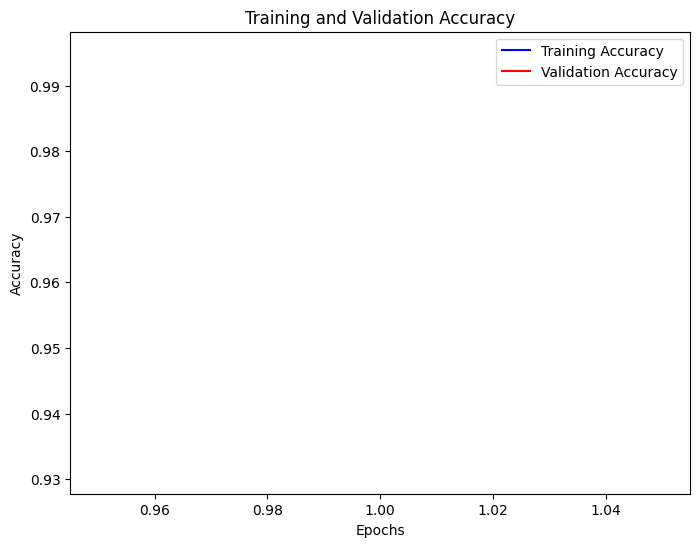

In [20]:
import matplotlib.pyplot as plt
 
# Extract accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
 
# Plot accuracy
fig = plt.figure(figsize=(8, 6))
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('binary_cnn.png', dpi=fig.dpi)

In [21]:
import tensorflow as tf
from sklearn.metrics import f1_score
import numpy as np

def f1_metric(y_true, y_pred):
    return tf.py_function(f1_score, (y_true, y_pred > 0.5), tf.float64)

# Define your grid search parameters
filter_options = [[32, 64, 128], [64, 128, 256]]  # Example: two sets of filters
dropout_options = [0.3, 0.5]  # Example: two dropout rates

best_accuracy = 0
best_params = {}

for filters in filter_options:
    for dropout_rate in dropout_options:
        model = Sequential([
            Conv2D(filters[0], (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(filters[1], (3, 3), padding='same', activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(filters[2], (3, 3), padding='same', activation='relu'),
            MaxPooling2D((2, 2)),
            Dropout(dropout_rate),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

        # Assuming images_train, labels_train, images_valid, labels_valid are already defined
        history = model.fit(images_train, labels_train, epochs=1, validation_data=(images_valid, labels_valid))

        val_accuracy = np.max(history.history['val_accuracy'])
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'filters': filters, 'dropout_rate': dropout_rate}

print(f"Best Validation Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")

# Best Validation Accuracy: 0.9947845935821533
# Best Hyperparameters: {'filters': [64, 128, 256], 'dropout_rate': 0.3}

1085/1088 [============================>.] - ETA: 0s - loss: 0.2534 - accuracy: 0.9192 - f1_metric: 0.9415

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 19s 17ms/step - loss: 0.2529 - accuracy: 0.9194 - f1_metric: 0.9417 - val_loss: 0.0186 - val_accuracy: 0.9934 - val_f1_metric: 0.7304


/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1086/1088 [============================>.] - ETA: 0s - loss: 0.3259 - accuracy: 0.8869 - f1_metric: 0.9168

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 20s 18ms/step - loss: 0.3255 - accuracy: 0.8870 - f1_metric: 0.9169 - val_loss: 0.0360 - val_accuracy: 0.9902 - val_f1_metric: 0.7285


/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.2715 - accuracy: 0.9150 - f1_metric: 0.9398

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.2460 - accuracy: 0.9179 - f1_metric: 0.9414

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 42s 39ms/step - loss: 0.2459 - accuracy: 0.9179 - f1_metric: 0.9415 - val_loss: 0.0483 - val_accuracy: 0.9791 - val_f1_metric: 0.7274
Best Validation Accuracy: 0.9947845935821533
Best Hyperparameters: {'filters': [64, 128, 256], 'dropout_rate': 0.3}


/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
